In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from utils.PINNnet import PINN
from utils.functions import green
from utils.plot_func import plot_field, model_pred_green, plot_error

In [2]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5

In [3]:
import joblib
state_dict = joblib.load('model_green.joblib')
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.load_state_dict(state_dict)
model = model.to(device)

In [4]:
# fixed parameters
N = 100
L = 1
Lx, Ly = L, L
L_pml = 0.5
src = [-0.4, 0.5]
src_imag = [src[0], 2 - src[1]]
k = 2 * np.pi * 20 / 1500 * 100

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


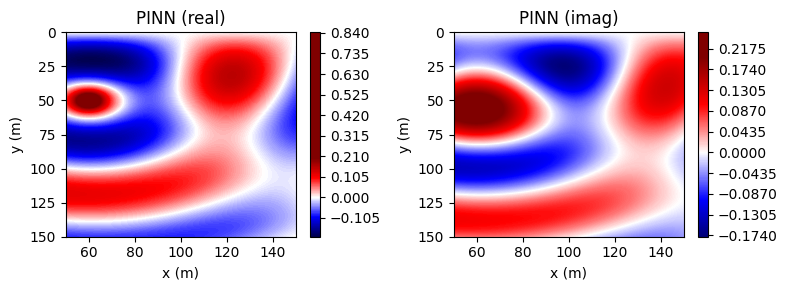

In [5]:
model_pred_green(model, Lx, Ly, L_pml, green=green, src=src, k=k, guide_mode='half')

In [6]:
x, y = torch.linspace(-(Lx - L_pml), (Lx - L_pml), N), torch.linspace(-(Ly - L_pml), Ly, N)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

g = green(x, y, src, k=k, is_tensor=False) - green(x, y, src_imag, k=k, is_tensor=False)
p_ref = g[:, 0] + 1j * g[:, 1]
p_ref = p_ref.reshape(N, N)

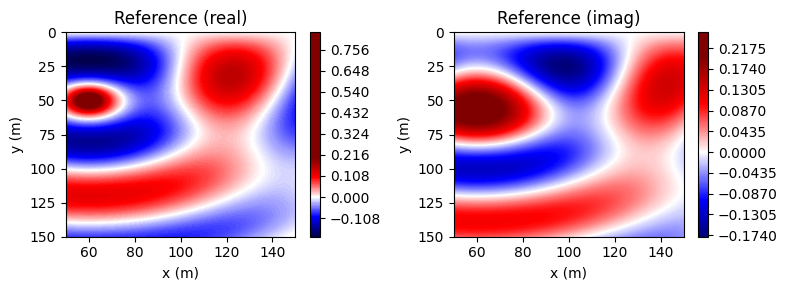

In [11]:
plot_field(p_ref, [50, 150], [-150, 0], bar_max=0.2, title='Reference', filename='Reference')

In [12]:
x, y = torch.tensor(x), torch.tensor(y)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = -model(inputs)[:, 0:1].detach().numpy()
p_imag = model(inputs)[:, 1:2].detach().numpy()
g = green(x, y, src, k, device='cpu').numpy()
p_real, p_imag = p_real.reshape(N, N) + g[:, 0].reshape(N, N), p_imag.reshape(N, N) + g[:, 1].reshape(N, N)
p = p_real + 1j * p_imag

/tmp/ipykernel_33510/1844674989.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)


Error(Real) 0.04522573575377464, Error(Imag) 0.041537489742040634


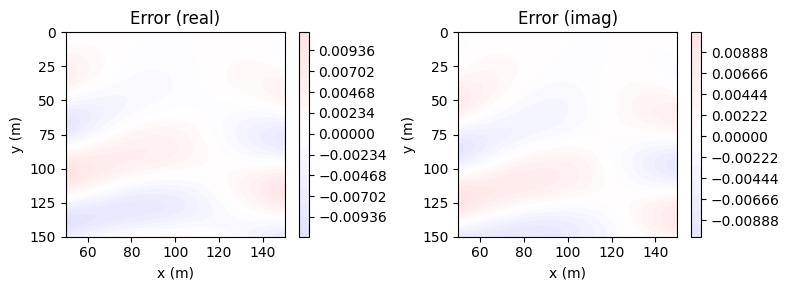

In [13]:
plot_error(p, p_ref, x, y)

In [1]:
loss = np.load('loss.npy')
loss = loss.tolist()

selected_loss = [loss[i] for i in range(44, len(loss), 50)]

plt.plot(np.arange(0, len(loss)), selected_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Loss (Source in free space)')
plt.savefig('loss')

NameError: name 'np' is not defined